In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import PIL
from PIL import Image, ImageOps

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

os.listdir(f'hw5_data/train/')  # Directory where training data folders are

['Store',
 'LivingRoom',
 'Coast',
 'OpenCountry',
 'Street',
 'Forest',
 'Office',
 'TallBuilding',
 'Highway',
 'Kitchen',
 'InsideCity',
 'Suburb',
 'Mountain',
 'Industrial',
 'Bedroom']

### # Hyperparameters

In [2]:
batch_size = 64  # Training batch size
num_classes = 15  # Classes in dataset
num_epochs = 40   # Epochs for training   
lr = 1e-3  # Learning rate
lr_weight_decay = 1e-3 # Learning weight decay

### Data Processing

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

"""
from albumentations.augmentations.transforms import Rotate
from albumentations import Compose

def augment_and_show(image):
    #image = Equalize(mode='pil', always_apply=True, p=1)(image=np.array(image).astype('uint8'))['image']
    aug = Compose([Rotate(limit=5, interpolation=2, p=1)])
    image = aug(image=image)['image']
    return image.astype('float')
"""

# preprocessing image and divide validaiton set
train_datagen = ImageDataGenerator(horizontal_flip=True, brightness_range=[0.5,1.5], zoom_range=[0.8,1])

train_generator = train_datagen.flow_from_directory('hw5_data/train/',
                                                 target_size=(256,256),
                                                 batch_size=batch_size,
                                                 class_mode='sparse',
                                                 shuffle=True,
                                                 subset='training')

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory('hw5_data/test/',target_size=(256,256),
                                                 batch_size=batch_size,
                                                 class_mode='sparse')


# for i in range(25):
#     plt.figure(figsize=(30,20))
#     plt.subplot(5,5,i+1)
#     plt.imshow(train_generator.next()[0][i].astype('uint8'))
#     plt.tight_layout()

Found 1500 images belonging to 15 classes.
Found 150 images belonging to 15 classes.


In [4]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

from classification_models.tfkeras import Classifiers

ResNet50, preprocess_input = Classifiers.get('resnet50')
base_model = ResNet50(input_shape=(256, 256, 3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(num_classes, kernel_initializer='zeros')(x)
model = Model(inputs=[base_model.input], outputs=[output])


# Training with the final custom-made layers
# ResNet 50 (48,51)
for layer in model.layers[:48]:
    layer.trainable =False
    
        
for layer in model.layers[48:]:
    layer.trainable=True
    
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

### Callbacks

In [5]:
import math
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras import backend as K


class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=1):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
cosineanneling = CosineAnnealingScheduler(T_max=5, eta_max=1e-2, eta_min=1e-5)


checkpoint = ModelCheckpoint('logs/ep{epoch:03}-val_loss{val_loss:.3f}.h5', save_best_only=False, save_weight_only=True, monitor='val_loss', mode='min', verbose=1)

In [6]:
from tensorflow.keras import optimizers
# Use default adam optimizer (learning rate=1e-3, decay=0)
# Loss function: categorical cross entropy
# Evaluation: Accuracy

sgd = optimizers.SGD(lr=1e-3, momentum=0.9, decay=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])


step_size_train = train_generator.n // train_generator.batch_size
step_size_val = validation_generator.n // validation_generator.batch_size

history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
                              validation_data=validation_generator, validation_steps=step_size_val,
                              epochs=num_epochs , callbacks=[cosineanneling, checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: CosineAnnealingScheduler setting learning rate to 0.01.
Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.5945 - accuracy: 0.5577
Epoch 00001: saving model to logs/ep001-val_loss0.708.h5
23/23 [==============================] - 17s 740ms/step - loss: 1.5945 - accuracy: 0.5577 - val_loss: 0.7085 - val_accuracy: 0.7109 - lr: 0.0100

Epoch 00002: CosineAnnealingScheduler setting learning rate to 0.009046039886902862.
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8990
Epoch 00002: saving model to logs/ep002-val_loss0.565.h5
23/23 [==============================] - 16s 715ms/step - loss: 0.2974 - accuracy: 0.8990 - val_loss: 0.5652 - val_accuracy: 0.7969 - lr: 0.0090

Epoch 00003: CosineAnnealingScheduler setting learning rate to 0.006548539886902863.
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9


Epoch 00022: CosineAnnealingScheduler setting learning rate to 0.009046039886902864.
Epoch 22/40
23/23 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000
Epoch 00022: saving model to logs/ep022-val_loss0.163.h5
23/23 [==============================] - 17s 748ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.1625 - val_accuracy: 0.9453 - lr: 0.0090

Epoch 00023: CosineAnnealingScheduler setting learning rate to 0.006548539886902874.
Epoch 23/40
23/23 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9986
Epoch 00023: saving model to logs/ep023-val_loss0.164.h5
23/23 [==============================] - 16s 717ms/step - loss: 0.0059 - accuracy: 0.9986 - val_loss: 0.1635 - val_accuracy: 0.9453 - lr: 0.0065

Epoch 00024: CosineAnnealingScheduler setting learning rate to 0.0034614601130971406.
Epoch 24/40
23/23 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9986
Epoch 00024: saving model to logs/ep024-val_loss0.13

### Multi-GPU

In [7]:
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.models import Model
# import efficientnet.tfkeras as efn 
# import tensorflow as tf
# from tensorflow.keras import optimizers

# def get_compiled_model():

#     base_model = efn.EfficientNetB0(input_shape=(256, 256, 3), weights='imagenet', include_top=False)  # or weights='noisy-student'
#     x = GlobalAveragePooling2D()(base_model.output)
#     output = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=[base_model.input], outputs=[output])
    
# #     for layer in model.layers[:22]:
# #         layer.trainable =False

# #     for layer in model.layers[22:]:
# #         layer.trainable=True

#     sgd = optimizers.SGD(lr=1e-3, momentum=0.9, decay=1e-3)
#     model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
#     return model

# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))



# step_size_train = train_generator.n // train_generator.batch_size
# step_size_val = validation_generator.n // validation_generator.batch_size


# with strategy.scope():
#   # Everything that creates variables should be under the strategy scope.
#   # In general this is only model construction & `compile()`.
#     model = get_compiled_model()
   
    
# history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
#                               validation_data=validation_generator, validation_steps=step_size_val,
#                               epochs=num_epochs , callbacks=[cosineanneling, checkpoint])

### Visualization

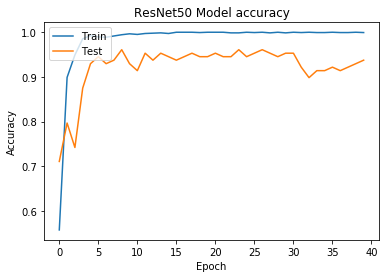

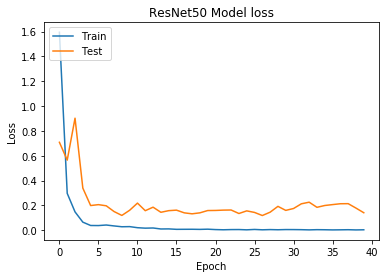

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Testing

In [9]:
class_label =  os.listdir(f'hw5_data/train/')

def DataLoader(path, standardize=False):
    img_list = []
    label_list = []
    num_img = 0
    for classes in class_label:
        for img in os.listdir(f'hw5_data/{path}/{classes}'):
            if img.endswith('.jpg'):
                label_list.append(classes)
                original = cv2.imread(f'hw5_data/{path}/{classes}/{img}')
                

                #original = augment_and_show(original)
                resized_img = cv2.resize(original, (256, 256), interpolation=cv2.INTER_CUBIC)

                img_list.append(resized_img)
                num_img += 1
    #img_list = img_list.T[1:,:]
    return np.array(img_list), label_list, num_img


test_img, test_label, num_test = DataLoader('test', standardize=False)

dic = train_generator.class_indices
label_num = []

for label in test_label:
    label_num.append(dic[label])

In [10]:
#B0 imagenet batch_size 64 0.92(rand) -> nosiey 0.906
#B1 imagenet batch_size 64 0.926(rand) -> nosiey 0.906

#B4 imagenet batch_size 16 0.92 -> 0.946(flip)

#B4 imagenet batch_size 32 0.95
#B4 imagenet batch_size 32 0.89 layer1
#B4 imagenet batch_size 32 0.9 layer2

#B5 imagenet batch_size 16 0.926
#B6 imagenet batch_size 16 0.9 layer1
#B6 imagenet batch_size 16 0.926 layer2
#B6 imagenet batch_size 16 0.94 layer3 # batch size OOM 32
#B6 imagenet batch_size 16 0.85 layer4


# ResNet50 batch_size 64 0.953(flip)
# ResNet50 batch_size 64 0.966(random flip)
# + rotate 5 0.98
# + rotate 7 0.96
# + rotate 10 0.953
# ResNet50 batch_size 64 0.953(random flip + constrast_pil) -> 0.946
# ResNet50 batch_size 64 0.94(random flip + constrast_cv) -> 0.946
# ResNet50 batch_size 64 0.94(flip + constrast_pil) -> test 0.953
# ResNet50 batch_size 64 0.926(flip + constrast_cv) -> test 0.94

In [12]:
for log in sorted(os.listdir(f'./logs/')):
    model.load_weights(f'logs/{log}')
    print(log)
    print(np.count_nonzero(np.argmax(model.predict(test_img), axis=1) == label_num) / num_test)

ep001-val_loss0.708.h5
0.7266666666666667
ep002-val_loss0.565.h5
0.8133333333333334
ep003-val_loss0.903.h5
0.76
ep004-val_loss0.340.h5
0.8933333333333333
ep005-val_loss0.199.h5
0.92
ep006-val_loss0.207.h5
0.9333333333333333
ep007-val_loss0.197.h5
0.9466666666666667
ep008-val_loss0.151.h5
0.9466666666666667
ep009-val_loss0.120.h5
0.9533333333333334
ep010-val_loss0.162.h5
0.9466666666666667
ep011-val_loss0.219.h5
0.9133333333333333
ep012-val_loss0.158.h5
0.96
ep013-val_loss0.186.h5
0.9333333333333333
ep014-val_loss0.145.h5
0.9533333333333334
ep015-val_loss0.158.h5
0.9533333333333334
ep016-val_loss0.162.h5
0.9533333333333334
ep017-val_loss0.141.h5
0.9533333333333334
ep018-val_loss0.133.h5
0.9533333333333334
ep019-val_loss0.141.h5
0.9533333333333334
ep020-val_loss0.159.h5
0.94
ep021-val_loss0.160.h5
0.9466666666666667
ep022-val_loss0.163.h5
0.9533333333333334
ep023-val_loss0.164.h5
0.9466666666666667
ep024-val_loss0.135.h5
0.9533333333333334
ep025-val_loss0.157.h5
0.9533333333333334
ep026-